---
title: Time-Domain Fitting with AMARES
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150


While Fourier transforms and phase corrections are essential for visualizing spectra, quantitative Magnetic Resonance Spectroscopy (MRS) requires extracting exact metabolite concentrations. Time-domain fitting is the gold standard for this, especially for *in vivo* data where peaks strongly overlap or are distorted by baseline effects.

`xmris` integrates the powerful [pyAMARES](https://github.com/HawkMRS/pyAMARES) library to perform Advanced Method for Accurate, Robust and Efficient Spectral fitting (AMARES).

:::{dropdown} Why AMARES?

Here is a section from the pyAMARES [paper](https://doi.org/10.3390/diagnostics14232668):

AMARES models the MRS signal as a sum of exponentially damped sinusoids. It uses parameters such as chemical shift, linewidth, amplitude, phase, and spectral lineshape, which can be constrained by prior knowledge. This knowledge includes initial parameters, parameter ranges, and relationships between different peaks and can be readily obtained from published literature. Peaks outside the region of interest can be filtered out, and parameters without prior knowledge can be fitted.

In contrast, frequency-domain fitting methods like LCModel require all metabolites to be modeled as basis set spectra. While this approach reduces the number of parameters to fit, it requires additional effort to obtain basis set spectra through experiments or numerical simulations. Moreover, frequency-domain fitting strategies typically require well-phased absorptive spectra. AMARES circumvents the sometimes subjective and complicated phasing procedure, making it particularly effective for analyzing data with distorted phases due to long receiver dead times.

LCModel and AMARES have been compared directly and proven to be comparable, each with its own advantages. However, AMARES is often the preferred method for quantifying X-nuclei MRS data, such as 13C and 31P MRS, where spectra typically exhibit fewer peaks and less J-coupling compared to 1H MRS.
:::

## The N-Dimensional Advantage



Traditional fitting tools often force you to write `for` loops to fit multiple spectra (like in an MRSI grid or a dynamic time-series). In `xmris`, the `.xmr.fit_amares()` accessor handles this for you.

You pass in an N-dimensional `DataArray`, and the package automatically flattens the spatial dimensions, distributes the fitting across your CPU cores, and reconstructs the results into an aligned `xarray.Dataset`.

```mermaid
graph LR
    A[Input DataArray<br>Dims: Voxel, Time] --> B(xmris Auto-Flatten)
    B --> C{joblib/loky Parallel Pool}
    C -->|Worker 1| D[pyAMARES Fit<br>Voxel 0]
    C -->|Worker N| E[pyAMARES Fit<br>Voxel N]
    D --> F(xmris Reconstruct)
    E --> F
    F --> G[Output Dataset<br>Time Dims: raw, fit, residuals<br>Param Dims: amplitude, phase, snr...]
```

Let's create a synthetic MRSI dataset (multiple voxels) and quantify it in one line of code.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Ensure xmris accessors are registered
import xmris.core.accessor

## 1. Define Prior Knowledge
AMARES requires Prior Knowledge (PK) to know how many peaks to look for and what constraints to place on their parameters (amplitude, frequency, linewidth, phase). This is provided as a CSV file.

Let's write a simple 2-peak prior knowledge file to disk. We will model Phosphocreatine (PCr) at 0 ppm and an ATP peak at -7.5 ppm.

In [3]:
pk_csv_content = """Index,PCr,ATP
Initial Values,,
amplitude,10.0,5.0
chemicalshift,0.0,-7.5
linewidth,15.0,20.0
phase,0,0
g,0,0
Bounds,,
amplitude,"(0, ","(0, "
chemicalshift,"(-0.5, 0.5)","(-8.0, -7.0)"
linewidth,"(5.0, 30.0)","(10.0, 40.0)"
phase,"(-180, 180)","(-180, 180)"
g,"(0, 1)","(0, 1)"
"""

pk_path = Path("example_pk.csv")
pk_path.write_text(pk_csv_content)

278

## 2. Generate N-Dimensional Synthetic Data
We will simulate a 1D spatial array containing 5 voxels. To make it realistic, we will vary the amplitude of the PCr peak across the voxels, representing a spatial concentration gradient, while keeping ATP constant.

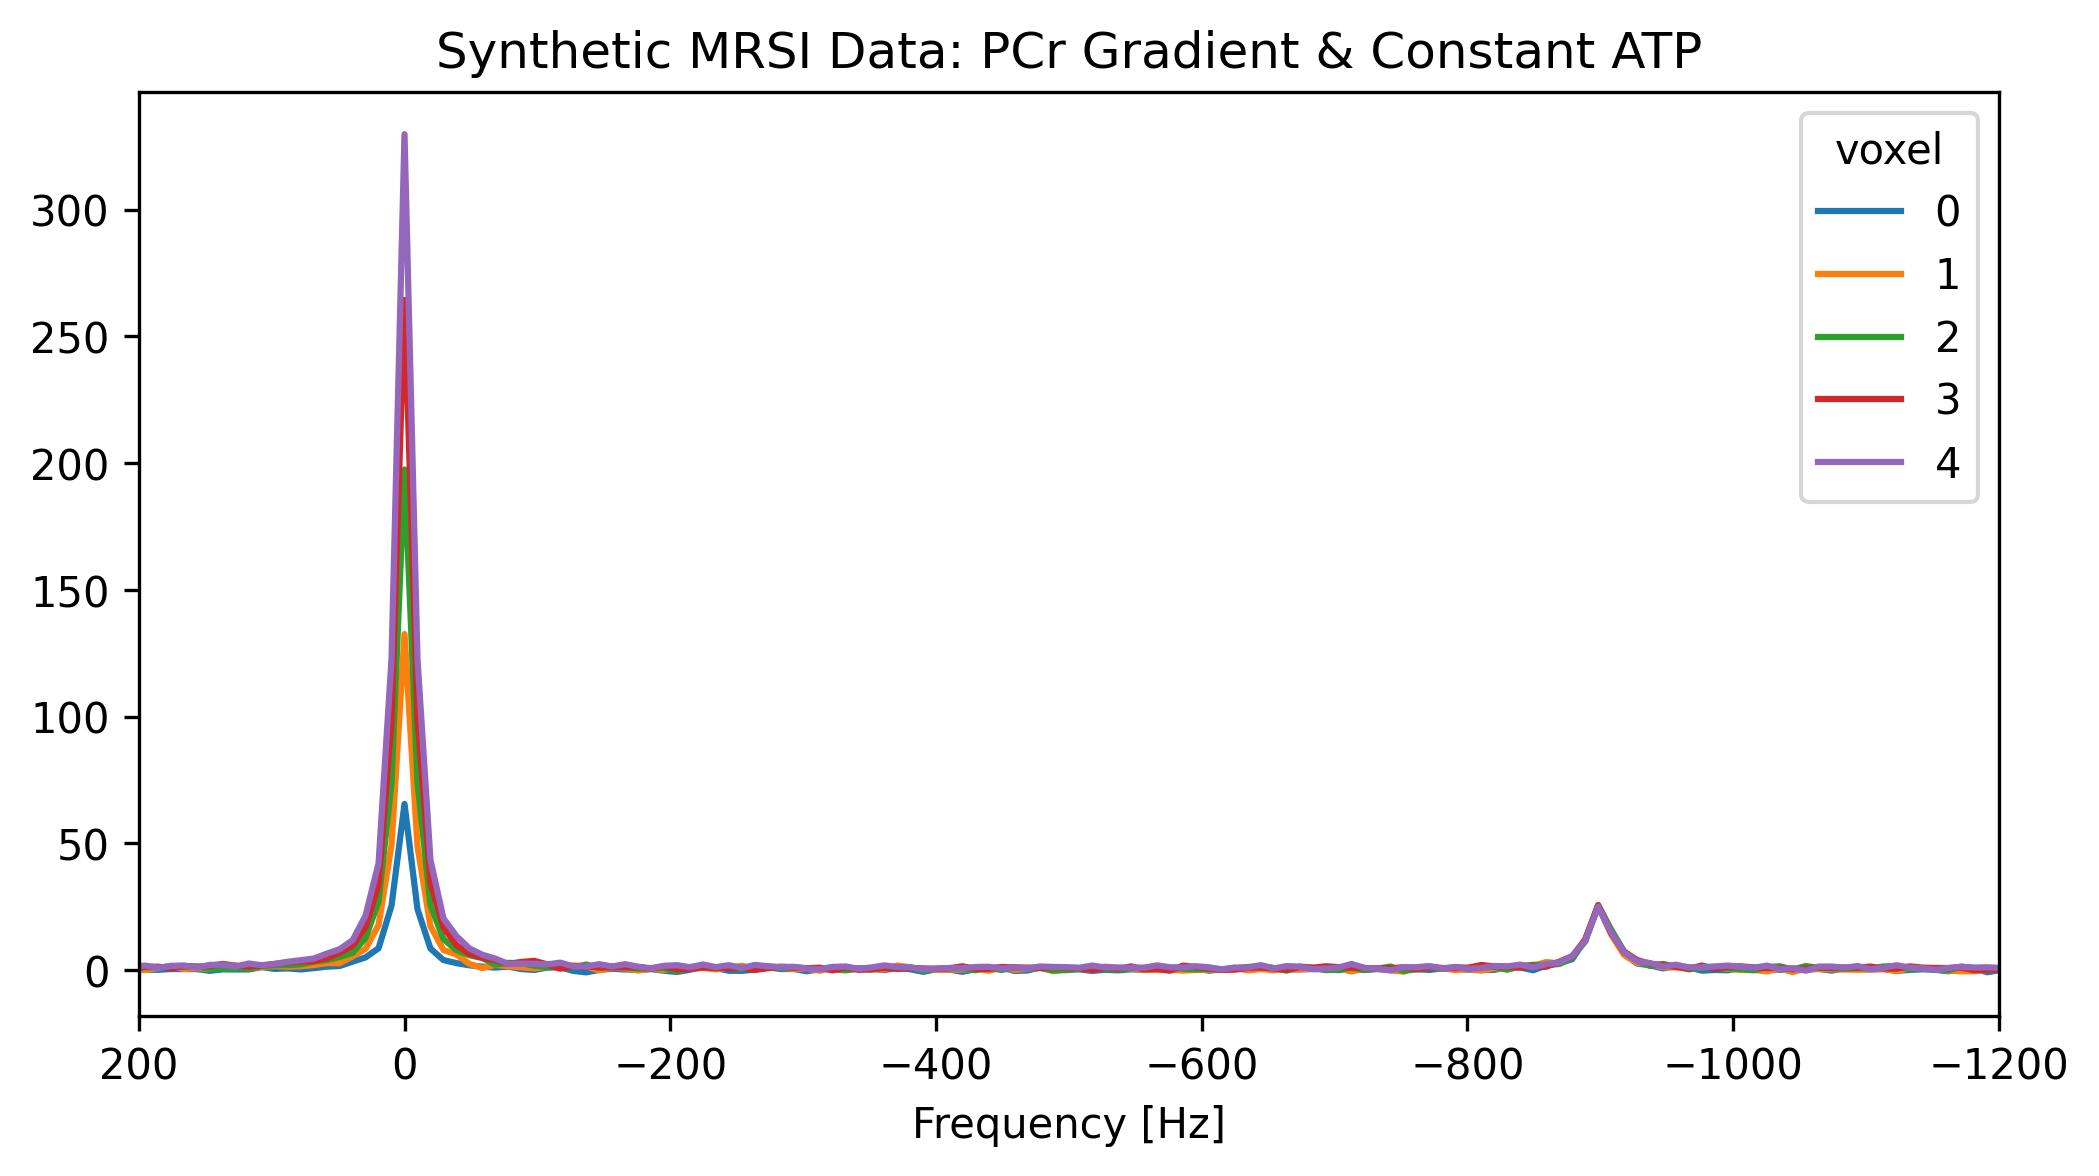

In [4]:
n_voxels = 5
n_points = 1024
sw = 10000.0  # Hz
mhz = 120.0  # 7T 31P
dt = 1.0 / sw
time = np.arange(n_points) * dt

# Pre-allocate the 2D array (Voxel x Time)
data = np.zeros((n_voxels, n_points), dtype=complex)

# True parameters (decay rate dk = linewidth * pi)
pcr_freq = 0.0 * mhz
atp_freq = -7.5 * mhz
decay_pcr = 15.0 * np.pi
decay_atp = 20.0 * np.pi

# Initialize random number generator
rng = np.random.default_rng(seed=42)

for v in range(n_voxels):
    # PCr amplitude increases across voxels (10 to 50)
    amp_pcr = 10.0 * (v + 1)
    # ATP amplitude is constant (5.0)
    amp_atp = 5.0

    # Generate pure FIDs
    fid_pcr = (
        amp_pcr * np.exp(-decay_pcr * time) * np.exp(1j * 2 * np.pi * pcr_freq * time)
    )
    fid_atp = (
        amp_atp * np.exp(-decay_atp * time) * np.exp(1j * 2 * np.pi * atp_freq * time)
    )

    # Combine and add noise
    signal = fid_pcr + fid_atp
    noise = rng.normal(0, 0.5, n_points) + 1j * rng.normal(0, 0.5, n_points)
    data[v, :] = signal + noise

# Package into an xarray DataArray
da_mrsi = xr.DataArray(
    data,
    dims=["voxel", "time"],
    coords={"voxel": np.arange(n_voxels), "time": time},
    attrs={"MHz": mhz, "sw": sw},
)

# Plot the generated spectra
spectra = da_mrsi.xmr.to_spectrum()

fig, ax = plt.subplots(figsize=(8, 4))
spectra.real.plot.line(x="frequency", hue="voxel", ax=ax, add_legend=True)
ax.set_xlim(200, -1200)  # Zoom into the peaks
ax.set_title("Synthetic MRSI Data: PCr Gradient & Constant ATP")
plt.show()

## 3. Fit the Data with xmris
We pass the `DataArray` to `.xmr.fit_amares()`.

Under the hood, `xmris` evaluates the Signal-to-Noise Ratio (SNR) of all voxels, picks the one with the highest SNR to safely initialize the `pyAMARES` template, and then parallelizes the fitting across your CPU cores.

In [5]:
# We use num_workers=4 to parallelize the fitting across our spatial dimensions!
ds_fit = da_mrsi.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=4
)

Auto-selected FID index 4 for initialization (SNR: 63.22)


Fitting Spectra:   0%|          | 0/5 [00:00<?, ?it/s]

[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!
Fitting 5 spectra with 4 workers took 1.91 seconds.


In [6]:
# Hidden cell for pytest-cov tracking, has to be a single thread with one worker only!
ds_fit = da_mrsi.xmr.fit_amares(
    prior_knowledge_file=pk_path, method="least_squares", num_workers=1
)

Auto-selected FID index 4 for initialization (SNR: 63.22)


Fitting Spectra (Single Core):   0%|          | 0/5 [00:00<?, ?it/s]

[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!


:::{dropdown} Understanding the PyAMARES Warning
If you look at the cell output above, you might notice this recurring warning:
`[AMARES | WARNING] pm_index are all NaNs, return None so that P matrix is a identity matrix!`

**This is completely normal and expected.** #
During the fitting process, PyAMARES calculates the Cramér-Rao Lower Bounds (CRLB) to estimate the mathematical uncertainty of your fit. To do this, it constructs a Prior Knowledge matrix (the "P matrix").

If your prior knowledge CSV does not contain explicit mathematical formulas linking the parameters of different peaks (for example, forcing the linewidth of ATP to exactly match the linewidth of PCr), the internal expression parser evaluates those empty relationships as `NaN`.

PyAMARES safely catches this and defaults the P matrix to an identity matrix. This simply means the algorithm is treating all peaks as mathematically independent, which is exactly what we want for this standard fit!
:::

### Exploring the Resulting Dataset

The returned `Dataset` is incredibly powerful. Instead of returning raw numbers, `xmris` neatly categorizes the fitting outputs into two sets of variables, mapped along their natural physical dimensions:

1. **Time-Domain Signals (`Voxel`, `Time`)**: The arrays `raw_data`, `fit_data`, and `residuals`.
2. **Quantified Parameters (`Voxel`, `Metabolite`)**: The tabular values such as `amplitude`, `chem_shift`, `linewidth`, `phase`, `crlb`, and `snr`.

:::{dropdown} Deep Dive: DataArray vs. Dataset
In the `xarray` ecosystem:
* **`DataArray`**: A single, N-dimensional array with labeled dimensions and coordinates (like a single physical quantity).
* **`Dataset`**: A dictionary-like container of multiple aligned `DataArray` objects that share dimensions.

Because fitting yields both continuous time-domain signals (mapped to `Time`) and discrete quantified parameters (mapped to a new `Metabolite` dimension), we use a `Dataset` to hold everything perfectly aligned in one neat package!

Read more in the [official xarray documentation](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset).
:::

Because it maps the results to the newly created `Metabolite` dimension, you can easily query and plot quantitative maps without touching a Pandas DataFrame or slicing NumPy arrays. Let's verify our spatial concentration gradient by plotting the fitted amplitudes across the voxels.

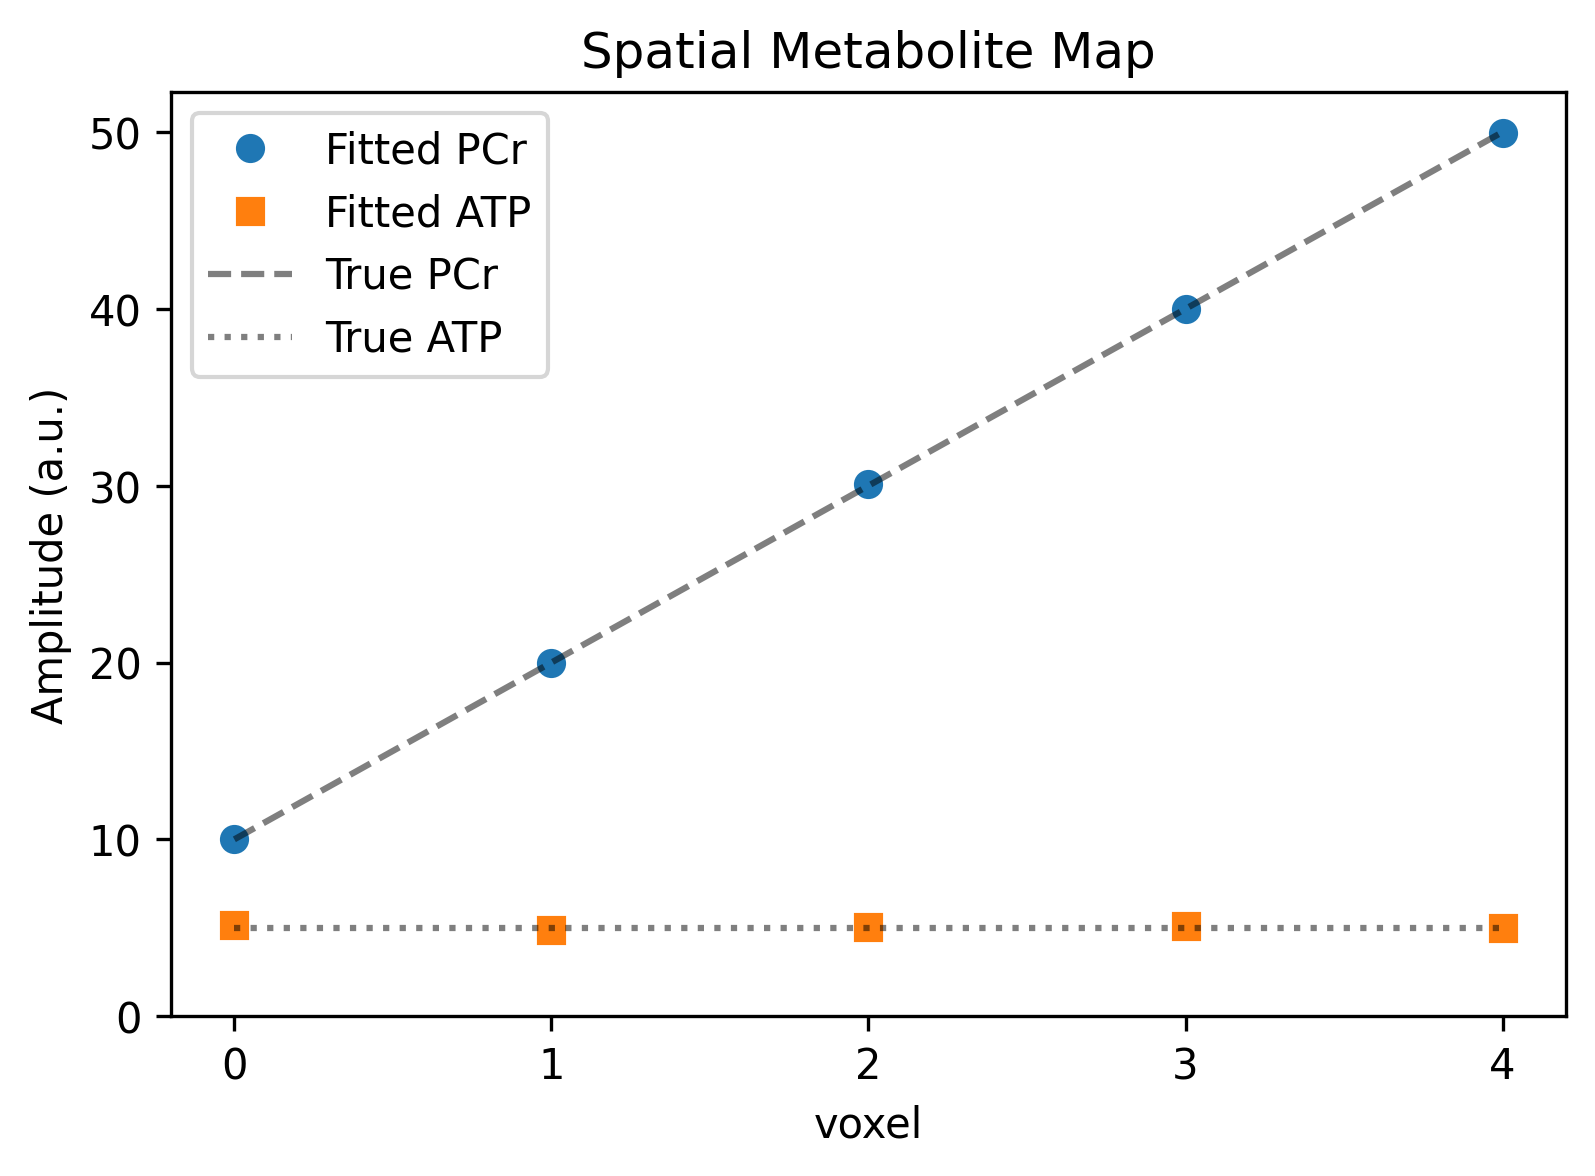

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))

# Because everything is aligned, plotting parameter maps is trivial
ds_fit.amplitude.sel(Metabolite="PCr").plot(
    ax=ax, marker="o", linestyle="none", label="Fitted PCr"
)
ds_fit.amplitude.sel(Metabolite="ATP").plot(
    ax=ax, marker="s", linestyle="none", label="Fitted ATP"
)

# Plot the ground truth for comparison
ax.plot(
    np.arange(n_voxels),
    [10 * (v + 1) for v in range(n_voxels)],
    "k--",
    alpha=0.5,
    label="True PCr",
)
ax.plot(
    np.arange(n_voxels),
    [5.0 for _ in range(n_voxels)],
    "k:",
    alpha=0.5,
    label="True ATP",
)

ax.set_ylim(bottom=0)  # Start y-axis at 0
ax.set_xticks(np.arange(n_voxels))  # Integer labels for voxels

ax.set_title("Spatial Metabolite Map")
ax.set_ylabel("Amplitude (a.u.)")
ax.legend()
plt.show()

### Quality Control (Tabular & Visual)

In quantitative MRS, simply looking at a plot is not enough to confirm a successful fit. The gold standard for assessing fit quality is the **Cramér-Rao Lower Bound (CRLB)**, which estimates the minimum variance of the fitted parameters.

A common rule of thumb is that **CRLB ≤ 20% indicates a reliable fit**.

Let's extract the exact fitting parameters for our final voxel (`Voxel=4`) from the `Dataset` and display them as a Pandas DataFrame. We will apply a custom style to highlight rows with acceptable CRLB values in green, mimicking the native behavior of `pyAMARES`.

In [9]:
# 1. Select the last voxel
voxel_idx = -1
last_voxel_ds = ds_fit.isel(voxel=voxel_idx)

# 2. Extract the quantified variables into a Pandas DataFrame
df_results = pd.DataFrame(
    {
        "Amplitude": last_voxel_ds.amplitude.values,
        "Chem Shift (ppm)": last_voxel_ds.chem_shift.values,
        "Linewidth (Hz)": last_voxel_ds.linewidth.values,
        "Phase (deg)": last_voxel_ds.phase.values,
        "SNR": last_voxel_ds.snr.values,
        "CRLB (%)": last_voxel_ds.crlb.values,
    },
    index=last_voxel_ds.Metabolite.values,
)

df_results.index.name = "Metabolite"


# 3. Define a styling function for the DataFrame
def highlight_crlb(row):
    """Highlight rows green if CRLB <= 20%, otherwise red."""
    if pd.isna(row["CRLB (%)"]):
        color = "background-color: rgba(255, 255, 0, 0.2)"  # Yellow for NaN/Failed
    elif row["CRLB (%)"] <= 20.0:
        color = "background-color: rgba(0, 255, 0, 0.2)"  # Green for Pass
    else:
        color = "background-color: rgba(255, 0, 0, 0.2)"  # Red for Fail
    return [color] * len(row)


# Display the styled dataframe (renders beautifully in Jupyter and MyST)
df_results.style.apply(highlight_crlb, axis=1).format("{:.3f}")

,Amplitude,Chem Shift (ppm),Linewidth (Hz),Phase (deg),SNR,CRLB (%)
Metabolite,,,,,,
PCr,49.967,0.000,14.976,-0.129,71.359,0.171
ATP,4.973,-7.497,20.006,-0.336,7.102,1.967


We can clearly see that both PCr and ATP converged beautifully, boasting high SNRs and CRLBs well below 20%.

Now, let's verify this visually by plotting the frequency-domain spectrum, the mathematical fit, and the residual noise for this exact same voxel.

Because `xmris` retained the reconstructed time-domain data inside our `Dataset`, we just use `.xmr.to_spectrum()` on the variables and plot them using standard `xarray` methods.

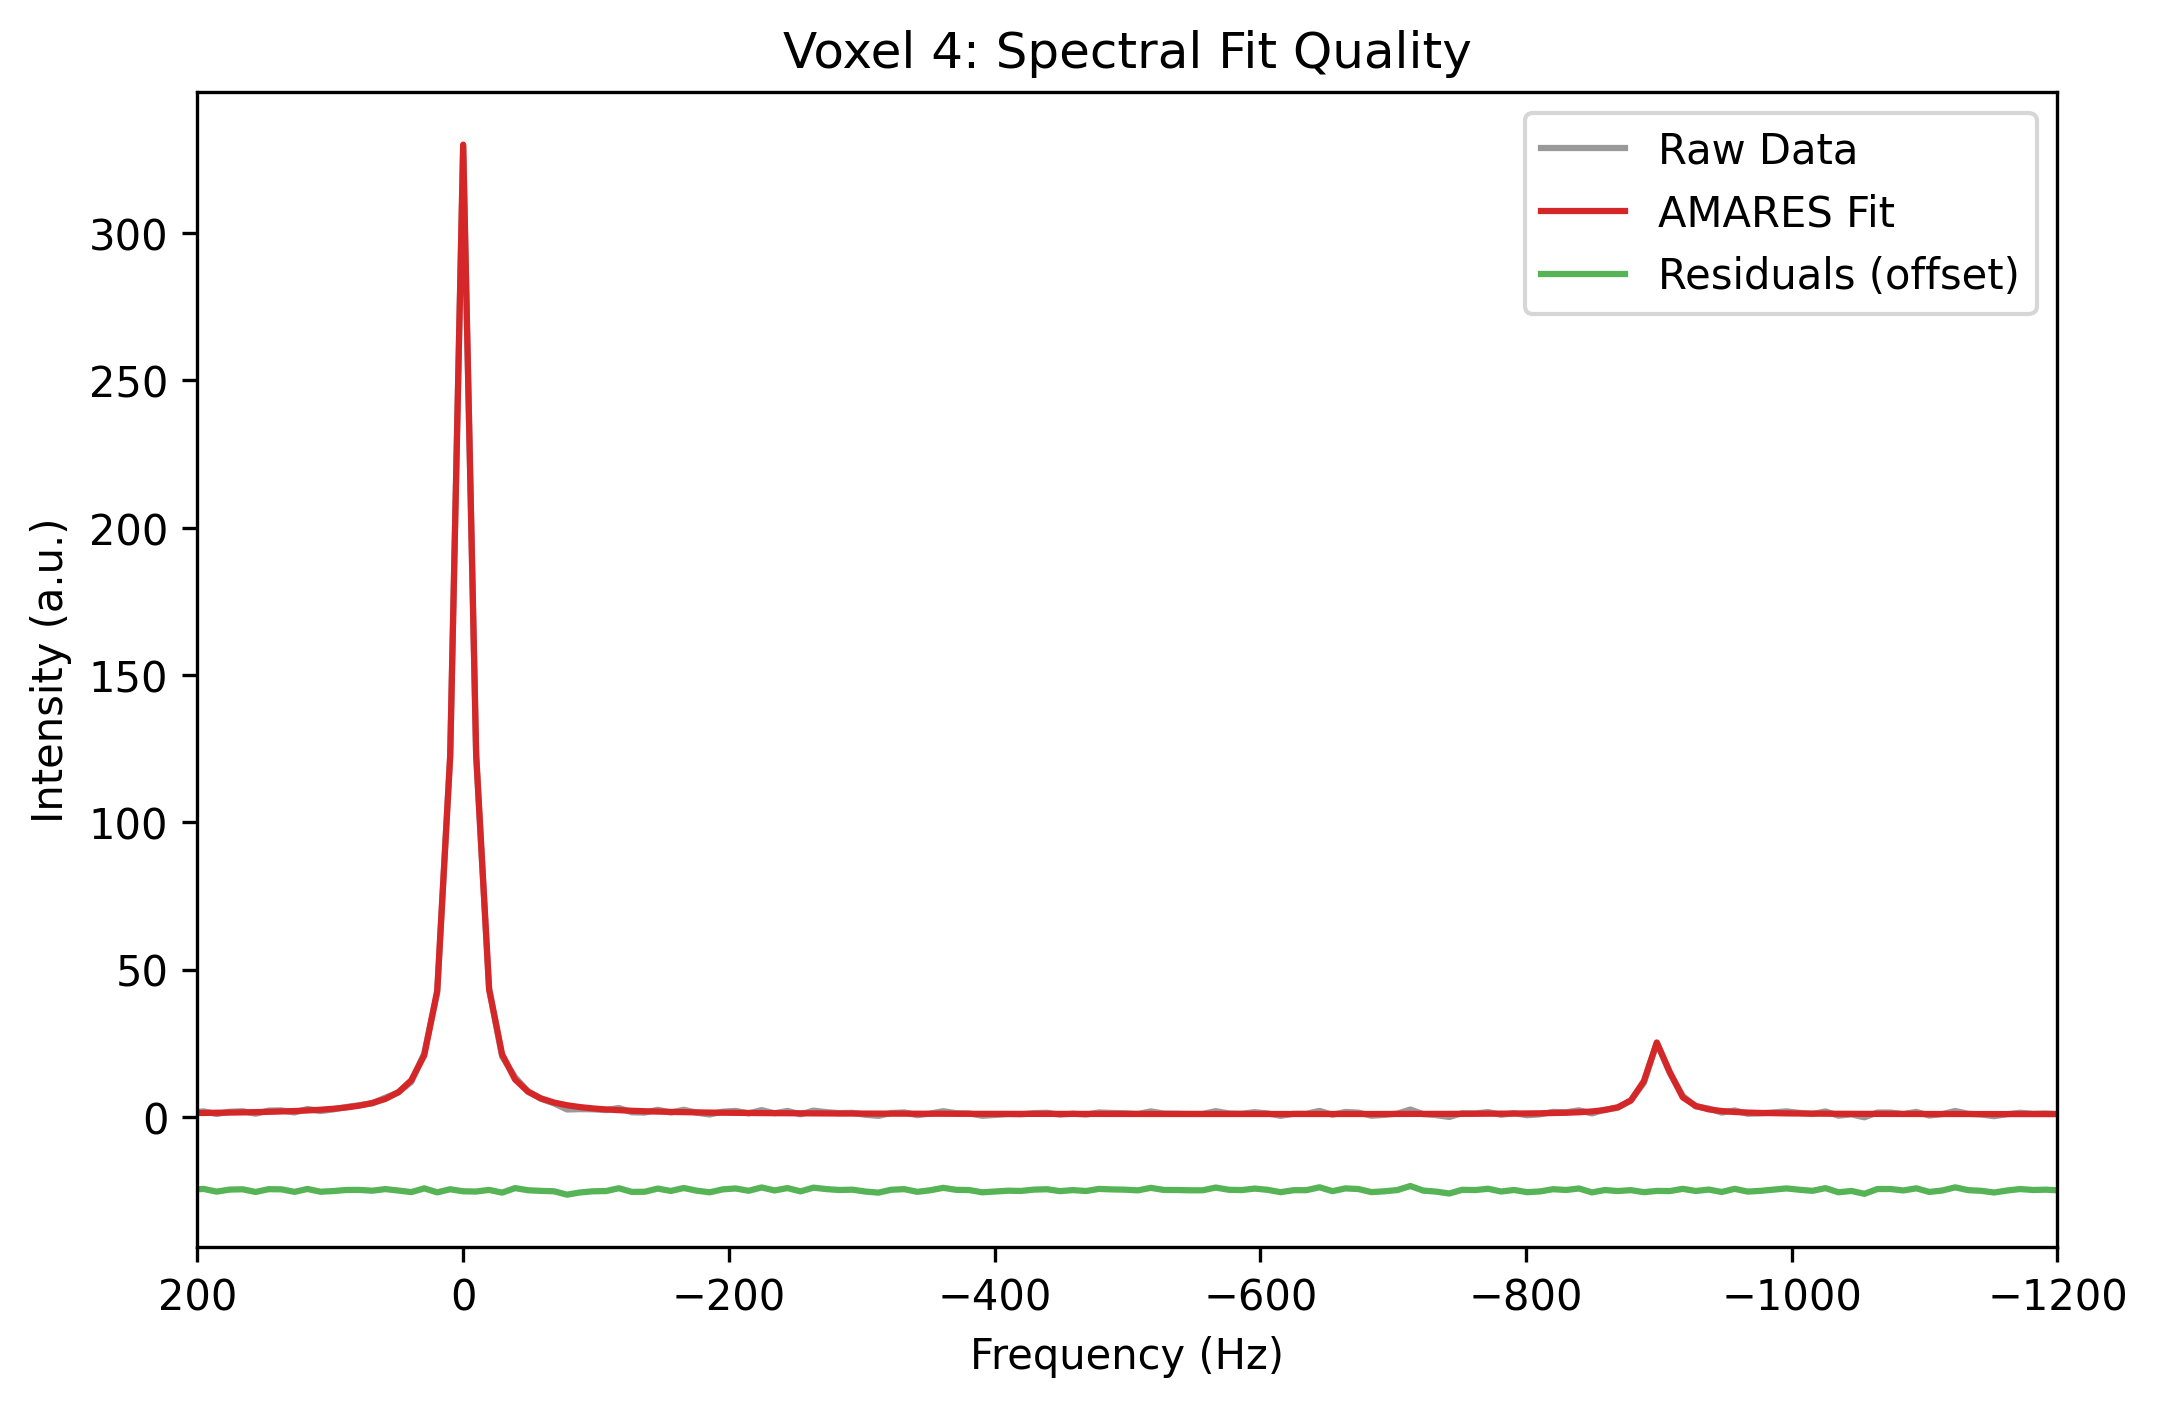

In [15]:
# Convert Time-domain arrays to Frequency-domain spectra for the last voxel
spec_raw = last_voxel_ds.raw_data.xmr.to_spectrum()
spec_fit = last_voxel_ds.fit_data.xmr.to_spectrum()
spec_res = last_voxel_ds.residuals.xmr.to_spectrum()

fig, ax = plt.subplots(figsize=(8, 5))

# Plot Real parts
ax.plot(
    spec_raw.coords["frequency"],
    spec_raw.real,
    color="black",
    alpha=0.4,
    label="Raw Data",
)
ax.plot(
    spec_fit.coords["frequency"],
    spec_fit.real,
    color="tab:red",
    linewidth=1.5,
    label="AMARES Fit",
)
ax.plot(
    spec_res.coords["frequency"],
    spec_res.real - 25,  # Offset the residuals downward for clarity
    color="tab:green",
    alpha=0.8,
    label="Residuals (offset)",
)

ax.set_xlim(200, -1200)  # Zoom into the region of interest
ax.set_title(f"Voxel {ds_fit.voxel.values[-1]}: Spectral Fit Quality")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Intensity (a.u.)")
ax.legend()
plt.show()

In [14]:
# CRITICAL ASSERTIONS FOR NBMAKE CI
# 1. Check Dataset generation and variables
assert isinstance(ds_fit, xr.Dataset), "Output must be an xarray Dataset"
expected_vars = [
    "raw_data",
    "fit_data",
    "residuals",
    "amplitude",
    "chem_shift",
    "linewidth",
    "phase",
    "crlb",
    "snr",
]
for v in expected_vars:
    assert v in ds_fit.data_vars, f"Variable {v} missing from Dataset"

# 2. Check Dimensional Alignment
assert ds_fit.amplitude.dims == ("voxel", "Metabolite"), (
    "Amplitude map dimensions are incorrect"
)
assert ds_fit.fit_data.dims == ("voxel", "time"), (
    "Reconstructed fit dimensions are incorrect"
)
assert len(ds_fit.coords["Metabolite"]) == 2, (
    "Should have found exactly 2 metabolites (PCr, ATP)"
)

# 3. Check Fit Accuracy (Quantitative)
fitted_pcr_amps = ds_fit.amplitude.sel(Metabolite="PCr").values
true_pcr_amps = np.array([10.0, 20.0, 30.0, 40.0, 50.0])
np.testing.assert_allclose(
    fitted_pcr_amps,
    true_pcr_amps,
    rtol=0.05,
    err_msg="PCr amplitudes were not fitted correctly",
)

fitted_atp_amps = ds_fit.amplitude.sel(Metabolite="ATP").values
true_atp_amps = np.array([5.0, 5.0, 5.0, 5.0, 5.0])
np.testing.assert_allclose(
    fitted_atp_amps,
    true_atp_amps,
    rtol=0.1,
    err_msg="ATP amplitudes were not fitted correctly",
)

# 4. Check Parametric Integrity
# Linewidth constraints check (should be between 5 and 40 Hz per PK)
assert np.all((ds_fit.linewidth.values >= 5.0) & (ds_fit.linewidth.values <= 40.0)), (
    "Linewidths violated PK constraints"
)

# SNR should be highest for the voxel with the largest amplitude (Voxel 4)
assert ds_fit.snr.sel(Metabolite="PCr").isel(voxel=4) > ds_fit.snr.sel(
    Metabolite="PCr"
).isel(voxel=0), "SNR mapping is incorrect"

# CRLB should be valid and acceptable for this high SNR synthetic data
assert not np.isnan(ds_fit.crlb.values).any(), (
    "CRLB contains NaNs, indicating an ill-conditioned fit matrix"
)
assert np.all(ds_fit.crlb.values <= 20.0), (
    "CRLB values exceeded 20% on clean synthetic data"
)

# 5. Check that residuals are mathematically correct and behave like noise
recalculated_residuals = ds_fit.raw_data - ds_fit.fit_data
xr.testing.assert_allclose(ds_fit.residuals, recalculated_residuals)

voxel_residual = ds_fit.residuals.isel(voxel=-1).values
assert abs(np.mean(voxel_residual)) < 1.0, (
    "Residuals are suspiciously high, indicating a bad fit"
)

# 6. Cleanup dummy PK file
pk_path.unlink(missing_ok=True)